In [65]:
import numpy as np

from astropy.io import fits 
from astropy import wcs
from astropy.wcs import WCS
import astropy.units as u
from astropy import stats
from astropy.nddata import Cutout2D
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd
from reproject.mosaicking import find_optimal_celestial_wcs

from fil_finder import FilFinder2D

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import tensorflow as tf
from tensorflow.keras import models, layers

from IPython import display
from tqdm.notebook import tqdm
import skimage.morphology

In [66]:
def Creating_cuts(file, a, b):
    
    data = file.data.squeeze()
    header = file.header
    w = WCS(header, naxis = 2)
    
    data = np.where(np.isnan(data), 0, data)
    data = data - np.min(data)

    num_a = data.shape[1]//a
    num_b = data.shape[0]//b
    size = ((a*u.pix, b*u.pix))
    
    HDUList = fits.HDUList([])  
    pbar = tqdm(total=num_a*num_b)
    
    n = 0
    while n < num_a:
        m = 0
        while m < num_b:
            
            cutout = Cutout2D(data, position=(a/2+n*a, b/2+m*b), size=size, wcs = w)
            new_header = cutout.wcs.to_header()
            hdu = fits.PrimaryHDU(cutout.data, header=new_header)
            HDUList.append(hdu)
            
            pbar.update(1)
            m+=1
        n+=1
    
    return HDUList, num_a, num_b

In [73]:
def Classification(images, model, num_a, num_b):
    
    np.seterr(divide='ignore', invalid='ignore')
    
    predictions = np.zeros((num_b, num_a))
    input_shape = (num_b,num_a,1)
    sigma = 1
    pbar = tqdm(total=predictions.size)
    
    f = 0
    n = 0
    while n < num_a:
        m = 0
        while m < num_b:
            
            
            image = images[f].data
            
#############Ensure this section is identical to preprocessing when training the CNN!
            image = image[..., tf.newaxis].astype('float32')
            mean, median, std = stats.sigma_clipped_stats(image, sigma=sigma)
            image[image < median+sigma*std] = median+sigma*std
            image = 2*((image-np.min(image))/np.ptp(image))-1
            image = np.where(np.isnan(image), 0, image)  
            image[image > 1] = 1
            image[image < -1] = -1
#####################################################################################
            
            pred = model.predict(image[np.newaxis, ...])
            predictions[m][n] = int(round(pred[0][0]))
            pbar.update(1)
            
            m+=1
            f+=1
        n+=1
           
    loc = np.argwhere(predictions)
    x = []
    y = []
    for i in range(len(loc)):
        x.append(loc[i][0])
        y.append(loc[i][1])
        
    dense = np.zeros((len(loc), len(loc)), dtype=bool)
    dense[y,x] = True
    labeled = skimage.morphology.label(dense, connectivity=2)
    coords = { i: (labeled == i).nonzero() for i in range(1,labeled.max()+1) }
    
    return coords    

In [74]:
def Stitching_Fits_Together(HDUList, coords, num_a, num_b, padding):
    
    i = 1
    f = 0
    N = num_a*num_b
    super_HDUList = fits.HDUList([])
    pbar = tqdm(total=len(coords))
    while i < len(coords)+1:
        x = coords[i][0]
        y = coords[i][1]
      
        if len(x)*len(y) > 1:   
            
            sub_HDUList = fits.HDUList([])
            j=0
            while j < len(y):
                sub_HDUList.append(HDUList[num_b*x[j]+y[j]])

                if padding:
                    if num_b*(x[j]+1)+y[j] <= N:
                        sub_HDUList.append(HDUList[num_b*(x[j]+1)+y[j]])
                    if num_b*(x[j]-1)+y[j] <= N:
                        sub_HDUList.append(HDUList[num_b*(x[j]-1)+y[j]])
                    if num_b*(x[j])+y[j]+1 <= N:
                        sub_HDUList.append(HDUList[num_b*(x[j])+y[j]+1])
                    if num_b*(x[j])+y[j]-1 <= N:
                        sub_HDUList.append(HDUList[num_b*(x[j])+y[j]-1])
                    if num_b*(x[j]+1)+y[j]+1 <= N:
                        sub_HDUList.append(HDUList[num_b*(x[j]+1)+y[j]+1])
                    if num_b*(x[j]-1)+y[j]+1 <= N:
                        sub_HDUList.append(HDUList[num_b*(x[j]-1)+y[j]+1])
                    if num_b*(x[j]+1)+y[j]-1 <= N:
                        sub_HDUList.append(HDUList[num_b*(x[j]+1)+y[j]-1])
                    if num_b*(x[j]-1)+y[j]-1 <= N:
                        sub_HDUList.append(HDUList[num_b*(x[j]-1)+y[j]-1])
                j+=1

            wcs_out, shape_out = find_optimal_celestial_wcs(sub_HDUList)
            array, footprint = reproject_and_coadd(sub_HDUList, wcs_out, shape_out=shape_out, reproject_function=reproject_interp)
            new_header = wcs_out.to_header()
            hdu = fits.PrimaryHDU(array, header=new_header)
            super_HDUList.append(hdu)           
        
        pbar.update(1)
        i+=1
      
    print(str(len(super_HDUList)) + " Filament regions detected. ")
    
    return super_HDUList

In [78]:
def Netfilex(filename, saved_model, a, b, padding):
    
    pbar = tqdm(total=3)
    
    HDUList, num_a, num_b = Creating_cuts(filename, a, b)
    pbar.update(1)
    
    coords = Classification(HDUList, saved_model, num_a, num_b)
    pbar.update(1)
    
    super_HDUList = Stitching_Fits_Together(HDUList, coords, num_a, num_b, padding)
    pbar.update(1)
    
    return super_HDUList

In [79]:
HDUList = fits.open(r"Raw Data\MeerKAT_radio_bubbles.fits")[0]
model = tf.keras.models.load_model(r"saved_models\modelBlueBEAR_0.9961212277412415_41_2_20")

In [80]:
#note this can take ~ 5-10 mins

super_HDUList = Netfilex(HDUList, model, 128, 128, padding=True)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5848 [00:00<?, ?it/s]

  0%|          | 0/5848 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

41 Filament regions detected. 


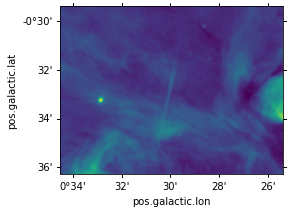

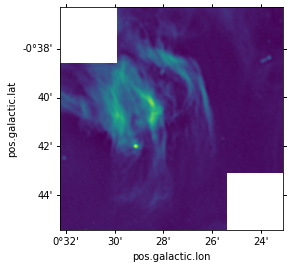

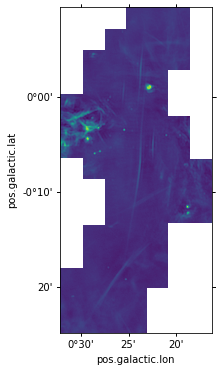

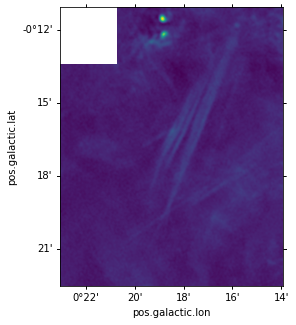

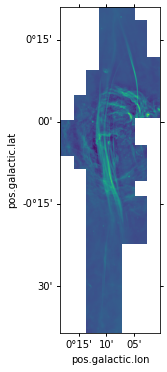

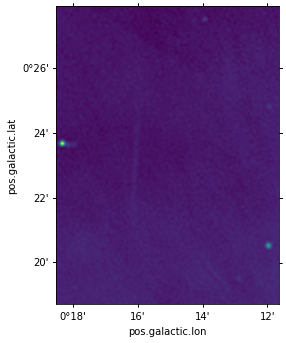

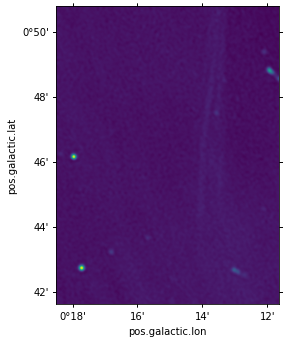

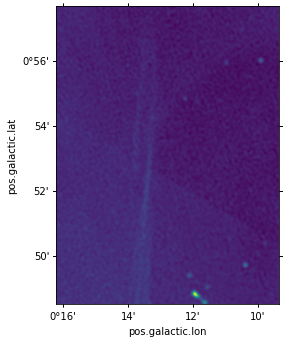

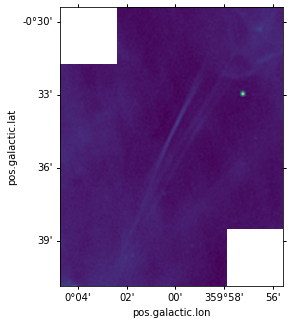

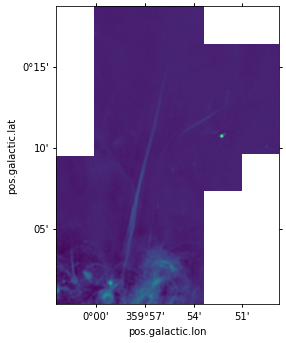

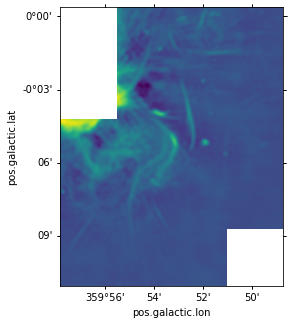

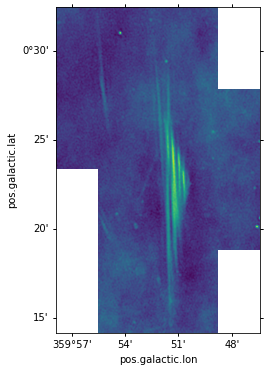

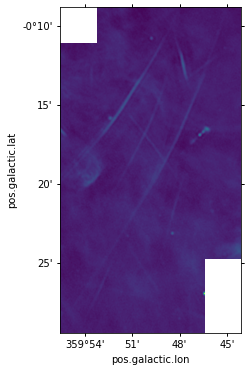

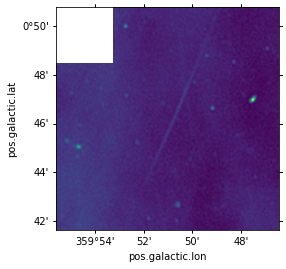

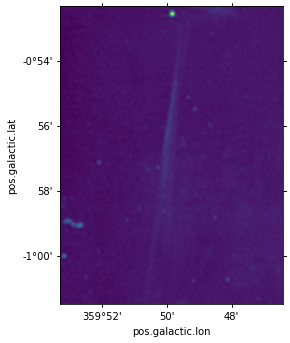

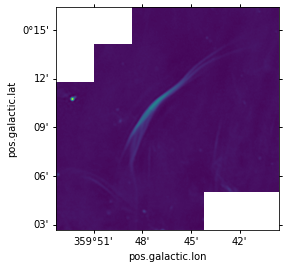

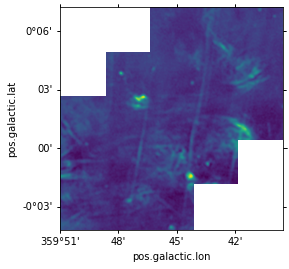

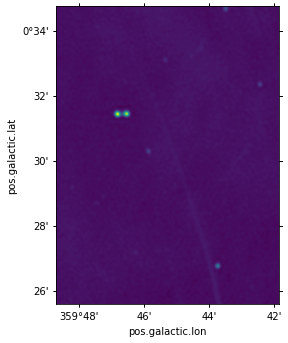

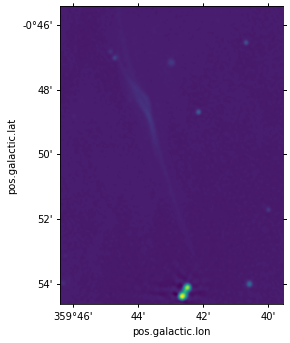

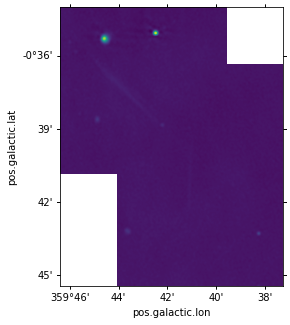

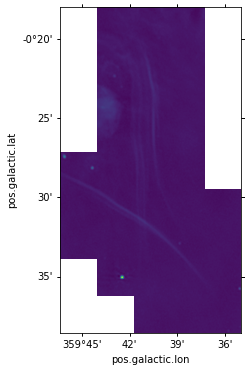

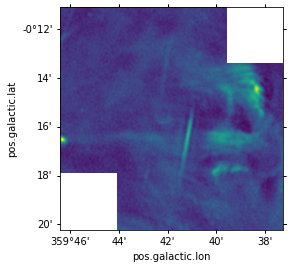

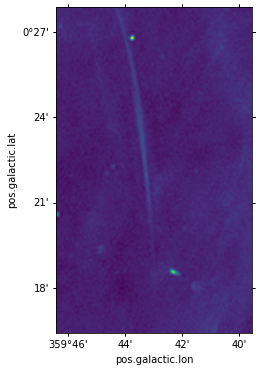

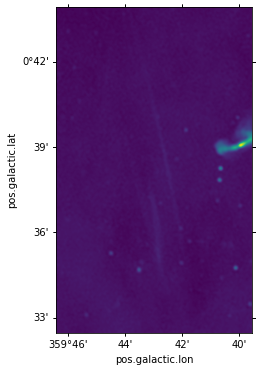

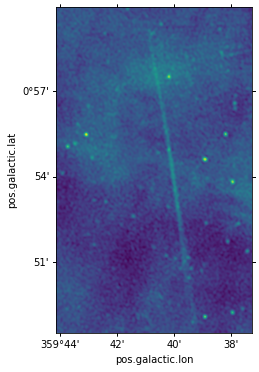

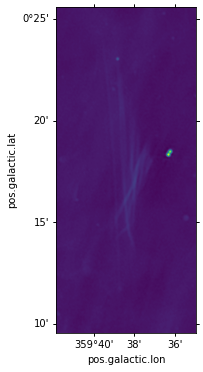

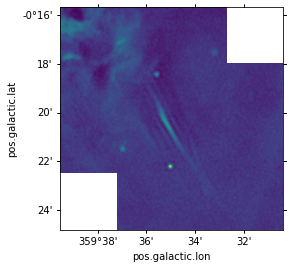

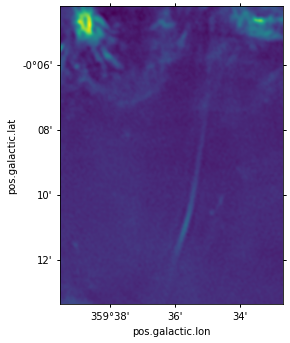

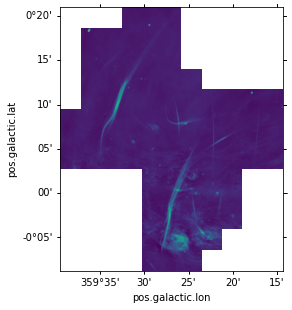

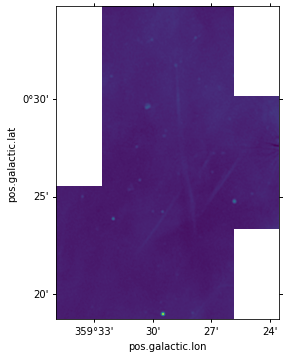

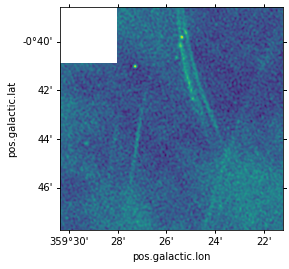

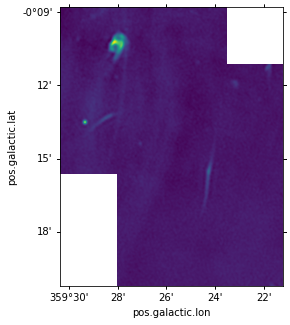

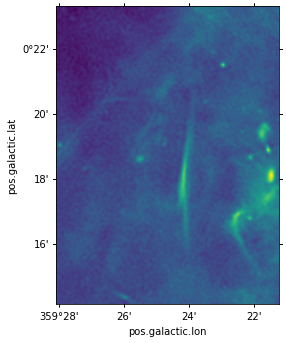

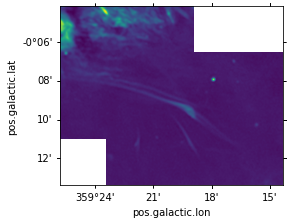

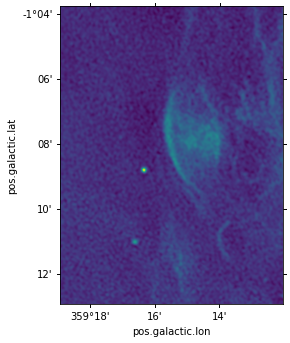

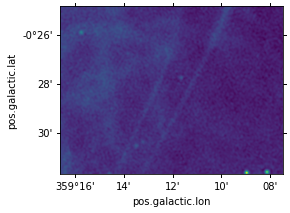

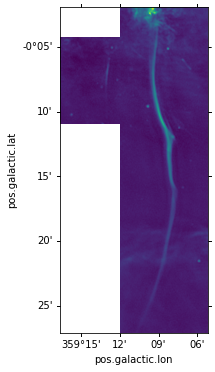

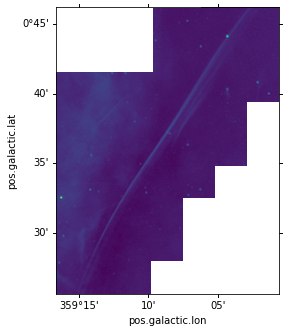

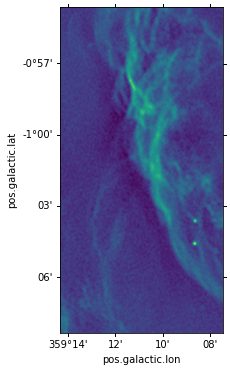

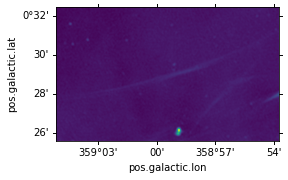

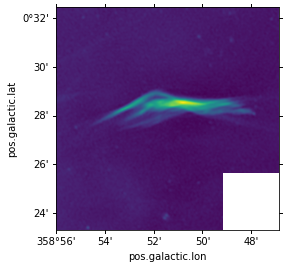

In [83]:
for i in range(len(super_HDUList)):
    
    hdu = super_HDUList[i]
    plt.figure(figsize=(4,6))
    wcs = WCS(hdu.header)
    plt.subplot(projection=wcs) 
    plt.imshow(hdu.data, origin='lower',  norm=colors.LogNorm()) 
    #plt.grid(color='k', ls='solid')
    plt.show()

In [84]:
super_HDUList.writeto(r"Data arrays\Mosaics\mosaics_modelBlueBEAR_0.9961212277412415_41_2_20.fits", overwrite=True)